# Exercise 2: Weighting Functions and radiative transfer in Clear sky

The main goals of this execise are:
1.  Learn how to write a code for computing the result of a complex formula
2.  Understand weighting functions

The student is asked to answer some questions after completing the notebook.

The first part of the notebook contains the definition of some functions, see the last part of the lession 3 slides for the comments.




In [1]:
import numpy as np
def calc_tau0(ka,Z,i0,i1):
    #calculates the nadir optical depth integrating ka*dZ between two levels i0 and i1
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two extreme levels for integration
    if i0<=i1:
        tau0=np.trapz(ka[i0:i1],Z[i0:i1])
    else:
        tau0=np.trapz(ka[i1:i0],Z[i1:i0])
    return tau0
def calc_gamma(ka,Z,i0,i1,UMU):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two levels for integration
    # UMU is cosine of the observation angle
    tau0=calc_tau0(ka,Z,i0,i1)
    gamma=np.exp(-1*tau0/UMU)
    return gamma

def calc_weighting_function(ka,Z,i,UMU,updir):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i the level of the weighting function
    # UMU is cosine of the observation angle
    # updir indicates if the weighting function
    #       is for radiaiton moving upward (updir=1)
    #       or downward (updir=0)
    if updir==1:
        gamma=calc_gamma(ka,Z,i,len(Z),UMU)
    else:
        gamma=calc_gamma(ka,Z,i,0,UMU)
    wf=ka[i]*gamma/UMU
    return wf
def calc_TB_DN(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed downward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=0)
    T_DN=np.trapz(wf*T,Z)
    return T_DN

def calc_TB_UP(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed upward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    T_UP=np.trapz(wf*T,Z)
    return T_UP

def plot_WF(wf1,Z):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = "ch "+str(iv+1))
    plt.ylim(0,60)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()

in the next cell first some parameters are set up, then the computation of the TBs observed by a radiometer on space and the upward weighting functions are calculated



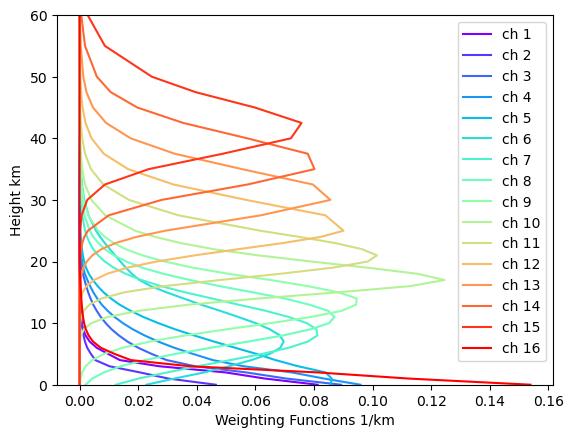

[242.77678867 226.55126731 254.61956146 264.31106345 269.7524807
 247.55621734 243.59884667 229.90396099 217.84760385 205.52859321
 212.19885539 220.52984207 231.37205734 243.84633657 254.32776564
 259.9643824 ]


In [11]:
from load_atm_prf import *
from gas_attenuation_rose98 import *
#profile_file_name='afgl_1986-subarctic_winter.nc'
# profile_file_name='afgl_1986-midlatitude_summer.nc'
profile_file_name='afgl_1986-tropical.nc'

Z,P,T,RH=load_atm__prf(profile_file_name)
T_surf=T[0]+0  # Surface temperature is taken as equal to the temperature of last layer
T[10]=T[10]+0

Z=Z*1000 # height from km to m

emis=0.7

Obs_angle=0 # in degrees

# frequencies from the satellite radiometer ATMS channels 1-16 
# see https://space.oscar.wmo.int/instruments/view/atms
Frequencies=[23.8, 
            31.4, 
            50.3, 
            51.76, 
            52.8, 
            53.95+0.115, 
            54.4, 
            54.94, 
            55.5, 
            57.290344,
            57.290344+0.217,  
            57.290344 +0.3222+0.048,
            57.290344 +0.3222+0.022,
            57.290344 +0.3222+0.010,
            57.290344 +0.3222+0.0045,
            88.2]


#---------------end of settings section ----------------------------------

UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

T_COS=2.7  # cosmic background radiation temperature
T_GAL=0.   # Radiation from the galaxy is approximated  to  0
T_SUN=0.   # Radiation from Sun  approximated  to  0

T_EXTRA=T_COS + T_GAL + T_SUN

TB=np.zeros(np.shape(Frequencies))
wf1=np.zeros((len(Z),len(Frequencies)))


for iv in range(len(Frequencies)):
    F=Frequencies[iv]
    ka=gas_abs(P, T, RH, F)
    
    gamma = calc_gamma(ka, Z, len(Z), 0,       UMU)
    
    T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward
    
    T_SS = (T_EXTRA*gamma + T_DN) *(1-emis) # TB reflected from the surface
    
    T_SE = emis*T_surf                        # TB emitted from the surface
    
    
    T_UP=calc_TB_UP(ka,Z,T,UMU)              # TB emitted by the atmosphere upward
    
    TB[iv]=  (T_SS+T_SE)*gamma  + T_UP
   
    for i in range(0,len(Z)):
        wf1[i,iv]=calc_weighting_function(ka,Z,i,UMU,updir=1)
plot_WF(wf1,Z)


print(TB)

## The Exercise

1. Plot weighting functions for the 6 input standard profiles
2. Fix the profile and change the Surface temperature (-20 K to +20 K)  and look how the TB changes
3. Fix the profile and the surface T, modify the temperature of one level (e.g. level 10) between -20 K and +20 K. Look the TBs that are affected by this change.

Advanced exercise:

4. Try to calculate the TB observed for the 5 standard profiles for an observer at the surface level.


# Execution  1: 
Plot weighting functions for the 6 input standard profiles

comment any change on the weighting function plot that you notice and that you find relevant




# Execution  2:
Fix the profile and change the Surface temperature (-20 K to +20 K) and look how the TB changes.

An increase/decrease of the surface temperature produces an increase/decrease of the observed TB for channels number ....
how is this connected to the weighting function plot?

(add any comment or plot you think is relevant)


# Execution 3:
Fix the profile and the surface T, modify the temperature of one level (e.g. level 10) between -20 K and +20 K. Look the TBs that are affected by this change. 

An increase/decrease of the temperature at level ... produces an increase/decrease of the observed TB for channels number ....

how is this connected to the weighting function plot?

(add any comment and plot you think is relevant)


# Execution 4:
Try to calculate the TB observed for the 5 standard profiles for an observer at the surface level.

write the code in the next cell and the figure of the weighting functions 